## Generating finite element sampling functions with sympy 

This notebook describes how to use `sympy` to generate symbolic expressions describing sampling of finite elements of different order. 



In [1]:
import sympy as sy
import numpy as np 

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

## 1D elements

Let's start with the 1D lagrange polynomial basis functions! 

https://www.longqi.cf/python/2014/03/24/implement-of-lagrange-polynomial-in-sympy/ has a nice implementation already: 

In [2]:
def LagrangPoly(x,order,i,xi=None):
    if xi==None:
        xi=sy.symbols('x:%d'%(order+1))
    index = range(order+1)    
    return sy.prod([(x-xi[j])/(xi[i]-xi[j]) for j in index if j != i])

where 𝑥 is a sympy symbol, order is the polynomial order (1 for linear, 2 for quadratic, 3 for cubic, etc.), 𝑖 the node index and 𝑥𝑖 are the node locations. If we run with order=2 and i=0 without node locations, we'll get the polynomial expression for 𝐿0: 

In [3]:
x=sy.symbols('x')
LagrangPoly(x,2,0)

(x - x1)*(x - x2)/((x0 - x1)*(x0 - x2))

For the rest of the notebook, we're going to use [-1,0,1] for the node locations in each dimension, so let's supply those to get a simpler expression: 

In [4]:
LP = LagrangPoly(x,2,0,[-1,0,1])
LP

-x*(1/2 - x/2)

In [5]:
sy.simplify(LP)

x*(x - 1)/2

The 2 basis functions for a 1D linear element are 

In [6]:
sy.pprint(
    (sy.simplify(LagrangPoly(x,1,0,[-1,1])),
    sy.simplify(LagrangPoly(x,1,1,[-1,1])))
)


⎛1   x  x   1⎞
⎜─ - ─, ─ + ─⎟
⎝2   2  2   2⎠


and then the 3 basis functions for a 1D quadratic element are 

In [7]:
sy.pprint(
    (sy.simplify(LagrangPoly(x,2,0,[-1,0,1])),
    sy.simplify(LagrangPoly(x,2,1,[-1,0,1])),
    sy.simplify(LagrangPoly(x,2,2,[-1,0,1]))
    )
)


⎛x⋅(x - 1)       2  x⋅(x + 1)⎞
⎜─────────, 1 - x , ─────────⎟
⎝    2                  2    ⎠


To get the functional form for evaluating at a point off a node, we also need the known values of the element at the nodes:

In [8]:
vals = [sy.symbols('f'+str(i)) for i in range(3)]
vals

[f0, f1, f2]

So our in-cell interpolation function for the linear element is 

In [9]:
shape_funcs = [
    sy.simplify(LagrangPoly(x,1,0,[-1,1])),
    sy.simplify(LagrangPoly(x,1,1,[-1,1]))
]
sample_expression = sum([vals[i]*shape_funcs[i] for i in range(2)])
sample_expression

f0*(1/2 - x/2) + f1*(x/2 + 1/2)

And for the quadratic: 

In [10]:
shape_funcs = [
    sy.simplify(LagrangPoly(x,2,0,[-1,0,1])),
    sy.simplify(LagrangPoly(x,2,1,[-1,0,1])),
    sy.simplify(LagrangPoly(x,2,2,[-1,0,1]))
]
sample_expression = sum([vals[i]*shape_funcs[i] for i in range(3)])
sample_expression

f0*x*(x - 1)/2 + f1*(1 - x**2) + f2*x*(x + 1)/2

## higher dimensions 

To construct the basis functions for higher dimensions, we simply multiply on another lagrange basis function for the new dimension. 

### linear rectangular element 
$2^2$ total nodes (4 corners): 

In [11]:

y=sy.symbols('y')
shape_funcs = []

for x_i in range(2):
    for y_i in range(2):
        LP1 = LagrangPoly(x,1,x_i,[-1,1])
        LP2 = LagrangPoly(y,1,y_i,[-1,1])
        shape_funcs.append(sy.simplify(LP2*LP1))
        
sy.pprint(shape_funcs)

⎡(x - 1)⋅(y - 1)  -(x - 1)⋅(y + 1)   -(x + 1)⋅(y - 1)   (x + 1)⋅(y + 1)⎤
⎢───────────────, ─────────────────, ─────────────────, ───────────────⎥
⎣       4                 4                  4                 4       ⎦


### quadratic rectangular element 

$3^3$ total nodes (4 corners, 4 edge-centers and 1 area-center):

In [12]:
shape_funcs = []

for x_i in range(3):
    for y_i in range(3):
        LP1 = LagrangPoly(x,2,x_i,[-1,0,1])
        LP2 = LagrangPoly(y,2,y_i,[-1,0,1])
        shape_funcs.append(sy.simplify(LP2*LP1))

for sf in shape_funcs:
    sy.pprint(sf)

x⋅y⋅(x - 1)⋅(y - 1)
───────────────────
         4         
-x⋅(x - 1)⋅(y - 1)⋅(y + 1) 
───────────────────────────
             2             
x⋅y⋅(x - 1)⋅(y + 1)
───────────────────
         4         
-y⋅(x - 1)⋅(x + 1)⋅(y - 1) 
───────────────────────────
             2             
(x - 1)⋅(x + 1)⋅(y - 1)⋅(y + 1)
-y⋅(x - 1)⋅(x + 1)⋅(y + 1) 
───────────────────────────
             2             
x⋅y⋅(x + 1)⋅(y - 1)
───────────────────
         4         
-x⋅(x + 1)⋅(y - 1)⋅(y + 1) 
───────────────────────────
             2             
x⋅y⋅(x + 1)⋅(y + 1)
───────────────────
         4         


### 3D linear hexahedral element 

$2^3=8$ total nodes (8 corner vertices): 

In [13]:
z=sy.symbols('z')
shape_funcs = []

for z_i in range(2):
    for y_i in range(2):
        for x_i in range(2):        
            LP1 = LagrangPoly(x,1,x_i,[-1,1])
            LP2 = LagrangPoly(y,1,y_i,[-1,1])
            LP3 = LagrangPoly(z,1,z_i,[-1,1])
            shape_funcs.append(sy.simplify(LP1 * LP2 * LP3))
        

for sf in shape_funcs:
    sy.pprint(sf) 

-(x - 1)⋅(y - 1)⋅(z - 1) 
─────────────────────────
            8            
(x + 1)⋅(y - 1)⋅(z - 1)
───────────────────────
           8           
(x - 1)⋅(y + 1)⋅(z - 1)
───────────────────────
           8           
-(x + 1)⋅(y + 1)⋅(z - 1) 
─────────────────────────
            8            
(x - 1)⋅(y - 1)⋅(z + 1)
───────────────────────
           8           
-(x + 1)⋅(y - 1)⋅(z + 1) 
─────────────────────────
            8            
-(x - 1)⋅(y + 1)⋅(z + 1) 
─────────────────────────
            8            
(x + 1)⋅(y + 1)⋅(z + 1)
───────────────────────
           8           


### 3D quadratic hexahedral element 

$3^3=27$ total nodes (8 corner vertices, 12 edge-centers, 6 face-centers, 1 volume-center): 

In [14]:
shape_funcs = []

for z_i in range(3):
    for y_i in range(3):
        for x_i in range(3):        
            LP1 = LagrangPoly(x,2,x_i,[-1,0,1])
            LP2 = LagrangPoly(y,2,y_i,[-1,0,1])
            LP3 = LagrangPoly(z,2,z_i,[-1,0,1])
            shape_funcs.append(sy.simplify(LP1 * LP2 * LP3))

for sf in shape_funcs:
    sy.pprint(sf)


x⋅y⋅z⋅(x - 1)⋅(y - 1)⋅(z - 1)
─────────────────────────────
              8              
-y⋅z⋅(x - 1)⋅(x + 1)⋅(y - 1)⋅(z - 1) 
─────────────────────────────────────
                  4                  
x⋅y⋅z⋅(x + 1)⋅(y - 1)⋅(z - 1)
─────────────────────────────
              8              
-x⋅z⋅(x - 1)⋅(y - 1)⋅(y + 1)⋅(z - 1) 
─────────────────────────────────────
                  4                  
z⋅(x - 1)⋅(x + 1)⋅(y - 1)⋅(y + 1)⋅(z - 1)
─────────────────────────────────────────
                    2                    
-x⋅z⋅(x + 1)⋅(y - 1)⋅(y + 1)⋅(z - 1) 
─────────────────────────────────────
                  4                  
x⋅y⋅z⋅(x - 1)⋅(y + 1)⋅(z - 1)
─────────────────────────────
              8              
-y⋅z⋅(x - 1)⋅(x + 1)⋅(y + 1)⋅(z - 1) 
─────────────────────────────────────
                  4                  
x⋅y⋅z⋅(x + 1)⋅(y + 1)⋅(z - 1)
─────────────────────────────
              8              
-x⋅y⋅(x - 1)⋅(y - 1)⋅(z - 1)⋅(z + 1) 
────────────────────

## node numbering

different FEM packages can use slightly different node number conventions. For example, the 3D quadratic hexahedral interpolation function would be given by 

In [15]:
vals = [sy.symbols('f'+str(i)) for i in range(27)]
sample_expression = sum([vals[i]*shape_funcs[i] for i in range(27)])
sample_expression

f0*x*y*z*(x - 1)*(y - 1)*(z - 1)/8 - f1*y*z*(x - 1)*(x + 1)*(y - 1)*(z - 1)/4 + f10*y*(x - 1)*(x + 1)*(y - 1)*(z - 1)*(z + 1)/2 - f11*x*y*(x + 1)*(y - 1)*(z - 1)*(z + 1)/4 + f12*x*(x - 1)*(y - 1)*(y + 1)*(z - 1)*(z + 1)/2 - f13*(x - 1)*(x + 1)*(y - 1)*(y + 1)*(z - 1)*(z + 1) + f14*x*(x + 1)*(y - 1)*(y + 1)*(z - 1)*(z + 1)/2 - f15*x*y*(x - 1)*(y + 1)*(z - 1)*(z + 1)/4 + f16*y*(x - 1)*(x + 1)*(y + 1)*(z - 1)*(z + 1)/2 - f17*x*y*(x + 1)*(y + 1)*(z - 1)*(z + 1)/4 + f18*x*y*z*(x - 1)*(y - 1)*(z + 1)/8 - f19*y*z*(x - 1)*(x + 1)*(y - 1)*(z + 1)/4 + f2*x*y*z*(x + 1)*(y - 1)*(z - 1)/8 + f20*x*y*z*(x + 1)*(y - 1)*(z + 1)/8 - f21*x*z*(x - 1)*(y - 1)*(y + 1)*(z + 1)/4 + f22*z*(x - 1)*(x + 1)*(y - 1)*(y + 1)*(z + 1)/2 - f23*x*z*(x + 1)*(y - 1)*(y + 1)*(z + 1)/4 + f24*x*y*z*(x - 1)*(y + 1)*(z + 1)/8 - f25*y*z*(x - 1)*(x + 1)*(y + 1)*(z + 1)/4 + f26*x*y*z*(x + 1)*(y + 1)*(z + 1)/8 - f3*x*z*(x - 1)*(y - 1)*(y + 1)*(z - 1)/4 + f4*z*(x - 1)*(x + 1)*(y - 1)*(y + 1)*(z - 1)/2 - f5*x*z*(x + 1)*(y - 1)*(y +

and while the first 8 nodes ($f_0$ to $f_7$) generally correspond to the 8 corner vertices, there is no set convention across FEM implementations. 

page 68 of https://fenicsproject.org/pub/documents/ufc/ufc-user-manual/ufc-user-manual.pdf describes the convention for UFC (used by fenics). 

## VTK_LAGRANGE_HEXAHEDRON node numbering convention 

The node numbering for the VTK_LAGRANGE_HEXAHEDRON (VTK type 72) is buried in the VTK source code: 

https://gitlab.kitware.com/vtk/vtk/-/blob/7a0b92864c96680b1f42ee84920df556fc6ebaa3/Common/DataModel/vtkHigherOrderInterpolation.cxx


Some other useful links:
* https://blog.kitware.com/modeling-arbitrary-order-lagrange-finite-elements-in-the-visualization-toolkit/
* https://github.com/Kitware/VTK/blob/0ce0d74e67927fd964a27c045d68e2f32b5f65f7/Common/DataModel/vtkCellType.h#L112
* https://github.com/ju-kreber/paraview-scripts
* https://discourse.paraview.org/t/about-high-order-non-traditional-lagrange-finite-element/1577/4

here's the VTK ordering: 

```
corners:                   edges:               

       z
7----------6            .----14----.      
|\     ^   |\           |\         |\     
| \    |   | \          | 15       | 13   
|  \   |   |  \         19 \       18 \   
|   4------+---5        |   .----12+---.  
|   |  +-- |-- | -> x   |   |      |   |  
3---+---\--2   |        .---+-10---.   |   
 \  |    \  \  |         \  16      \  17  
  \ |     \  \ |         11 |        9 |   
   \|      y  \|           \|         \|   
    0----------1            .----8-----.   
    
   
center-face node numbers 

y-z plane at x = -1 :   20 
y-z plane at x = +1 :   21
x-z plane at y = -1 :   22
x-z plane at y = +1 :   24
x-y plane at z = -1 :   23
x-y plane at z = +1 :   25

volume-center point node number: 26 
```

Note that edge numbers 18 and 19 were switched by this VTK PR https://gitlab.kitware.com/vtk/vtk/-/commit/7a0b92864c96680b1f42ee84920df556fc6ebaa3  The above numbering is for after VTK 9.0, before VTK 9.0 would require a check and switch. 
 

In [16]:
corner_coords = [
    [-1,-1,-1],
    [ 1,-1,-1],    
    [ 1, 1,-1],
    [-1, 1,-1],
    [-1,-1, 1],
    [ 1,-1, 1],
    [ 1, 1, 1],
    [-1, 1, 1],
]

# the corner nodes defining the edges
edge_nodes = [
    [0, 1], 
    [1, 2],
    [2, 3],
    [0, 3],
    [4, 5],
    [5, 6],
    [6, 7],
    [4, 7], 
    [0, 4],
    [1, 5],
    [2, 6],
    [3, 7],
]

# the corner nodes defning the faces
face_nodes = [ 
    [0,3,4,7],
    [1,2,5,6],
    [2,3,6,7],
    [0,1,2,3],
    [0,1,4,5],
    [4,5,6,7],
]



In [17]:
edge_coords = []
for edge in edge_nodes:
    edge_center = (np.array(corner_coords[edge[0]]) + np.array(corner_coords[edge[1]]))/2
    edge_coords.append(edge_center.tolist())
    
face_coords = []    
for face in face_nodes:
    coord = np.array([0,0,0])    
    for i in range(0,4):
        coord += np.array(corner_coords[face[i]]) 
    face_coords.append(coord/4)    

vol_center_coords=[np.array(corner_coords).sum(axis=0)/8]

In [18]:
corner_coords=np.array(corner_coords)
edge_coords=np.array(edge_coords)
face_coords=np.array(face_coords)
vol_center_coords=np.array(vol_center_coords)

<IPython.core.display.Javascript object>


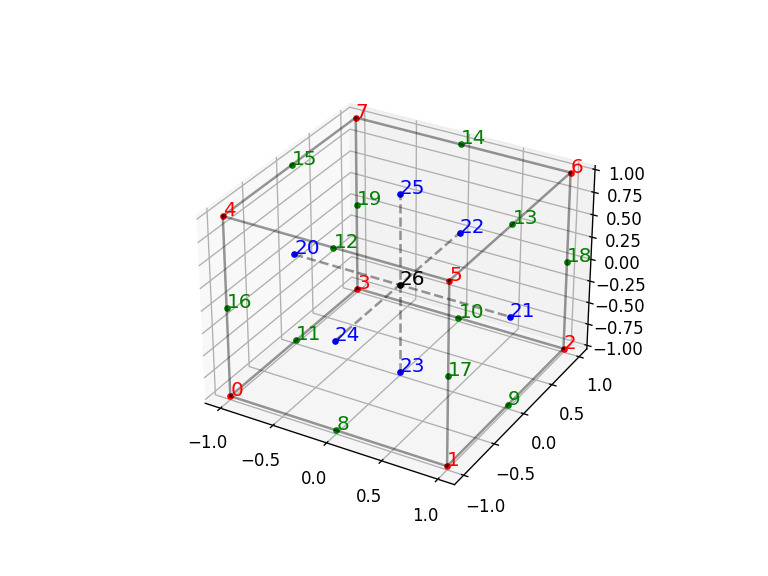

In [19]:
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')

node_num=0
clrs=['r','g','b','k']
type_num=0
all_coords = []
for coords in [corner_coords, edge_coords, face_coords, vol_center_coords]:   
    
    for node in coords:
        ax.plot(node[0],node[1],node[2],marker='.',color=clrs[type_num])
        ax.text(node[0],node[1],node[2], str(node_num),fontsize=12,color=clrs[type_num])
        all_coords.append(node)
        node_num+=1 
    type_num+=1

all_coords = np.array(all_coords)
lncol=[0,0,0,.4]
for xyz in [1,-1]:
    ax.plot([-1,1],[xyz,xyz],[xyz,xyz],color=lncol)
    ax.plot([xyz,xyz],[-1,1],[xyz,xyz],color=lncol)
    ax.plot([xyz,xyz],[xyz,xyz],[-1,1],color=lncol)    
    ax.plot([-1,1],[-xyz,-xyz],[xyz,xyz],color=lncol)
    ax.plot([-xyz,-xyz],[-1,1],[xyz,xyz],color=lncol)
    ax.plot([-xyz,-xyz],[xyz,xyz],[-1,1],color=lncol)    

ax.plot([-1,1],[0.,0.],[0.,0.],'--',color=lncol)    
ax.plot([0.,0.],[-1,1],[0.,0.],'--',color=lncol)    
ax.plot([0.,0.],[0.,0.],[-1,1],'--',color=lncol)

**So to build the proper interpolation function, we need to account for this node numbering:**

In [20]:
# corresponding quadratic lagrange poly 
shape_funcs = []
vtk_node_num = []
crd=[-1,0,1]
for z_i in range(3):
    for y_i in range(3):
        for x_i in range(3):        
            LP1 = LagrangPoly(x,2,x_i,crd)
            LP2 = LagrangPoly(y,2,y_i,crd)
            LP3 = LagrangPoly(z,2,z_i,crd)
            
            # find the VTK node number             
            indx = np.where((all_coords[:,0]==crd[x_i]) & (all_coords[:,1]==crd[y_i]) & (all_coords[:,2]==crd[z_i]))[0][0]                                   
            vtk_node_num.append(indx)
            shape_funcs.append(sy.simplify(LP1 * LP2 * LP3))
            

In [21]:
vals = [sy.symbols('f'+str(i)) for i in vtk_node_num]
sample_expression = sum([vals[i]*shape_funcs[i] for i in range(27)])
sample_expression

f0*x*y*z*(x - 1)*(y - 1)*(z - 1)/8 + f1*x*y*z*(x + 1)*(y - 1)*(z - 1)/8 - f10*y*z*(x - 1)*(x + 1)*(y + 1)*(z - 1)/4 - f11*x*z*(x - 1)*(y - 1)*(y + 1)*(z - 1)/4 - f12*y*z*(x - 1)*(x + 1)*(y - 1)*(z + 1)/4 - f13*x*z*(x + 1)*(y - 1)*(y + 1)*(z + 1)/4 - f14*y*z*(x - 1)*(x + 1)*(y + 1)*(z + 1)/4 - f15*x*z*(x - 1)*(y - 1)*(y + 1)*(z + 1)/4 - f16*x*y*(x - 1)*(y - 1)*(z - 1)*(z + 1)/4 - f17*x*y*(x + 1)*(y - 1)*(z - 1)*(z + 1)/4 - f18*x*y*(x + 1)*(y + 1)*(z - 1)*(z + 1)/4 - f19*x*y*(x - 1)*(y + 1)*(z - 1)*(z + 1)/4 + f2*x*y*z*(x + 1)*(y + 1)*(z - 1)/8 + f20*x*(x - 1)*(y - 1)*(y + 1)*(z - 1)*(z + 1)/2 + f21*x*(x + 1)*(y - 1)*(y + 1)*(z - 1)*(z + 1)/2 + f22*y*(x - 1)*(x + 1)*(y + 1)*(z - 1)*(z + 1)/2 + f23*z*(x - 1)*(x + 1)*(y - 1)*(y + 1)*(z - 1)/2 + f24*y*(x - 1)*(x + 1)*(y - 1)*(z - 1)*(z + 1)/2 + f25*z*(x - 1)*(x + 1)*(y - 1)*(y + 1)*(z + 1)/2 - f26*(x - 1)*(x + 1)*(y - 1)*(y + 1)*(z - 1)*(z + 1) + f3*x*y*z*(x - 1)*(y + 1)*(z - 1)/8 + f4*x*y*z*(x - 1)*(y - 1)*(z + 1)/8 + f5*x*y*z*(x + 1)*(y -